In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [38]:
df = pd.read_csv("./DF/train.csv")
df.shape

(1460, 81)

# Null Data
Dealing with null data

In [39]:
# How many null data do we have?

print ("Total null values: " ,df.isna().sum().sum())
df.columns

# Some columns doesn't have null values so let's see only the columns with any null value
columns_with_null_values = df[df.columns[df.isna().any()]].isna().sum()
print(columns_with_null_values)

Total null values:  6965
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


After examining some data I conclude that must of null values means that the property doesn't have the respective feature, for example, null values on Alley means that the house doesnt have a Alley access, so Ill add a value to denotate that the houses dont have the featured instead of have a null value.

I'll try to not remove rows since we dont have too much, and with more rows, the algorythm will be better trained.

In [40]:
# Null values for LotFrontage means that the houses have 0 feets since the street to the entrance, so the null values will be replaced with 0
df["LotFrontage"].fillna("None", inplace=True)

# Null values for Alley means that the houses dont have an alley entrance, so the null values will be replaced with None
df["Alley"].fillna("None", inplace=True)

# Null values for MasVnrType and MasVnrArea means that we dont know what kind of Masonry veneer type has the property or the area of it, since there are few null values here they will be replaced with None
df["MasVnrType"].fillna("None", inplace=True)
df["MasVnrArea"].fillna("None", inplace=True)

# FireplaceQu will be filled with None since it's asociate to the reason that there isnt fireplaces.
df["FireplaceQu"].fillna("None", inplace=True)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2 are related and im not sure how to treat it now, so i'll leave it as is
basement_columns=["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
df.loc[:, basement_columns] = df.loc[:, basement_columns].fillna("None")

# Since Electrical has only one null value I'll remove it (there are other fields of this row with null values)
null_index = df[df["Electrical"].isnull()].index
df.drop(null_index, axis=0, inplace=True)

# GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond null values will be filled with None indicating that the hose doesnt have garage, it based on GarageCars and GarageArea that are 0 for those rows.
garage_columns = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]
df.loc[:, garage_columns] = df.loc[:, garage_columns].fillna("None")

# PoolQC, Fence and MiscFeature will be filled with None, indicating that there isnt pool, fence or anothe miscelaneous furniture, this desition is taking in account that other fields as the pool area that indicates the missing of it.
other_columns = ["PoolQC", "Fence" ,"MiscFeature"]
df.loc[:, other_columns] = df.loc[:, other_columns].fillna("None")

Converting object data into category data

In [41]:
object_columns = df.select_dtypes(include=["object"])
df[object_columns.columns] = df[object_columns.columns].astype("category")

lbl = LabelEncoder()
for column in object_columns.columns:
    df[column] = lbl.fit_transform(df[column].astype("str"))

In [42]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,75,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,90,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,78,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,70,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,94,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000


# Splitting data and creating X and Y Dataframes

In [43]:
X = df.drop(["SalePrice"], axis=1)
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_data = X_train.join(y_train)

# Knowing The Data

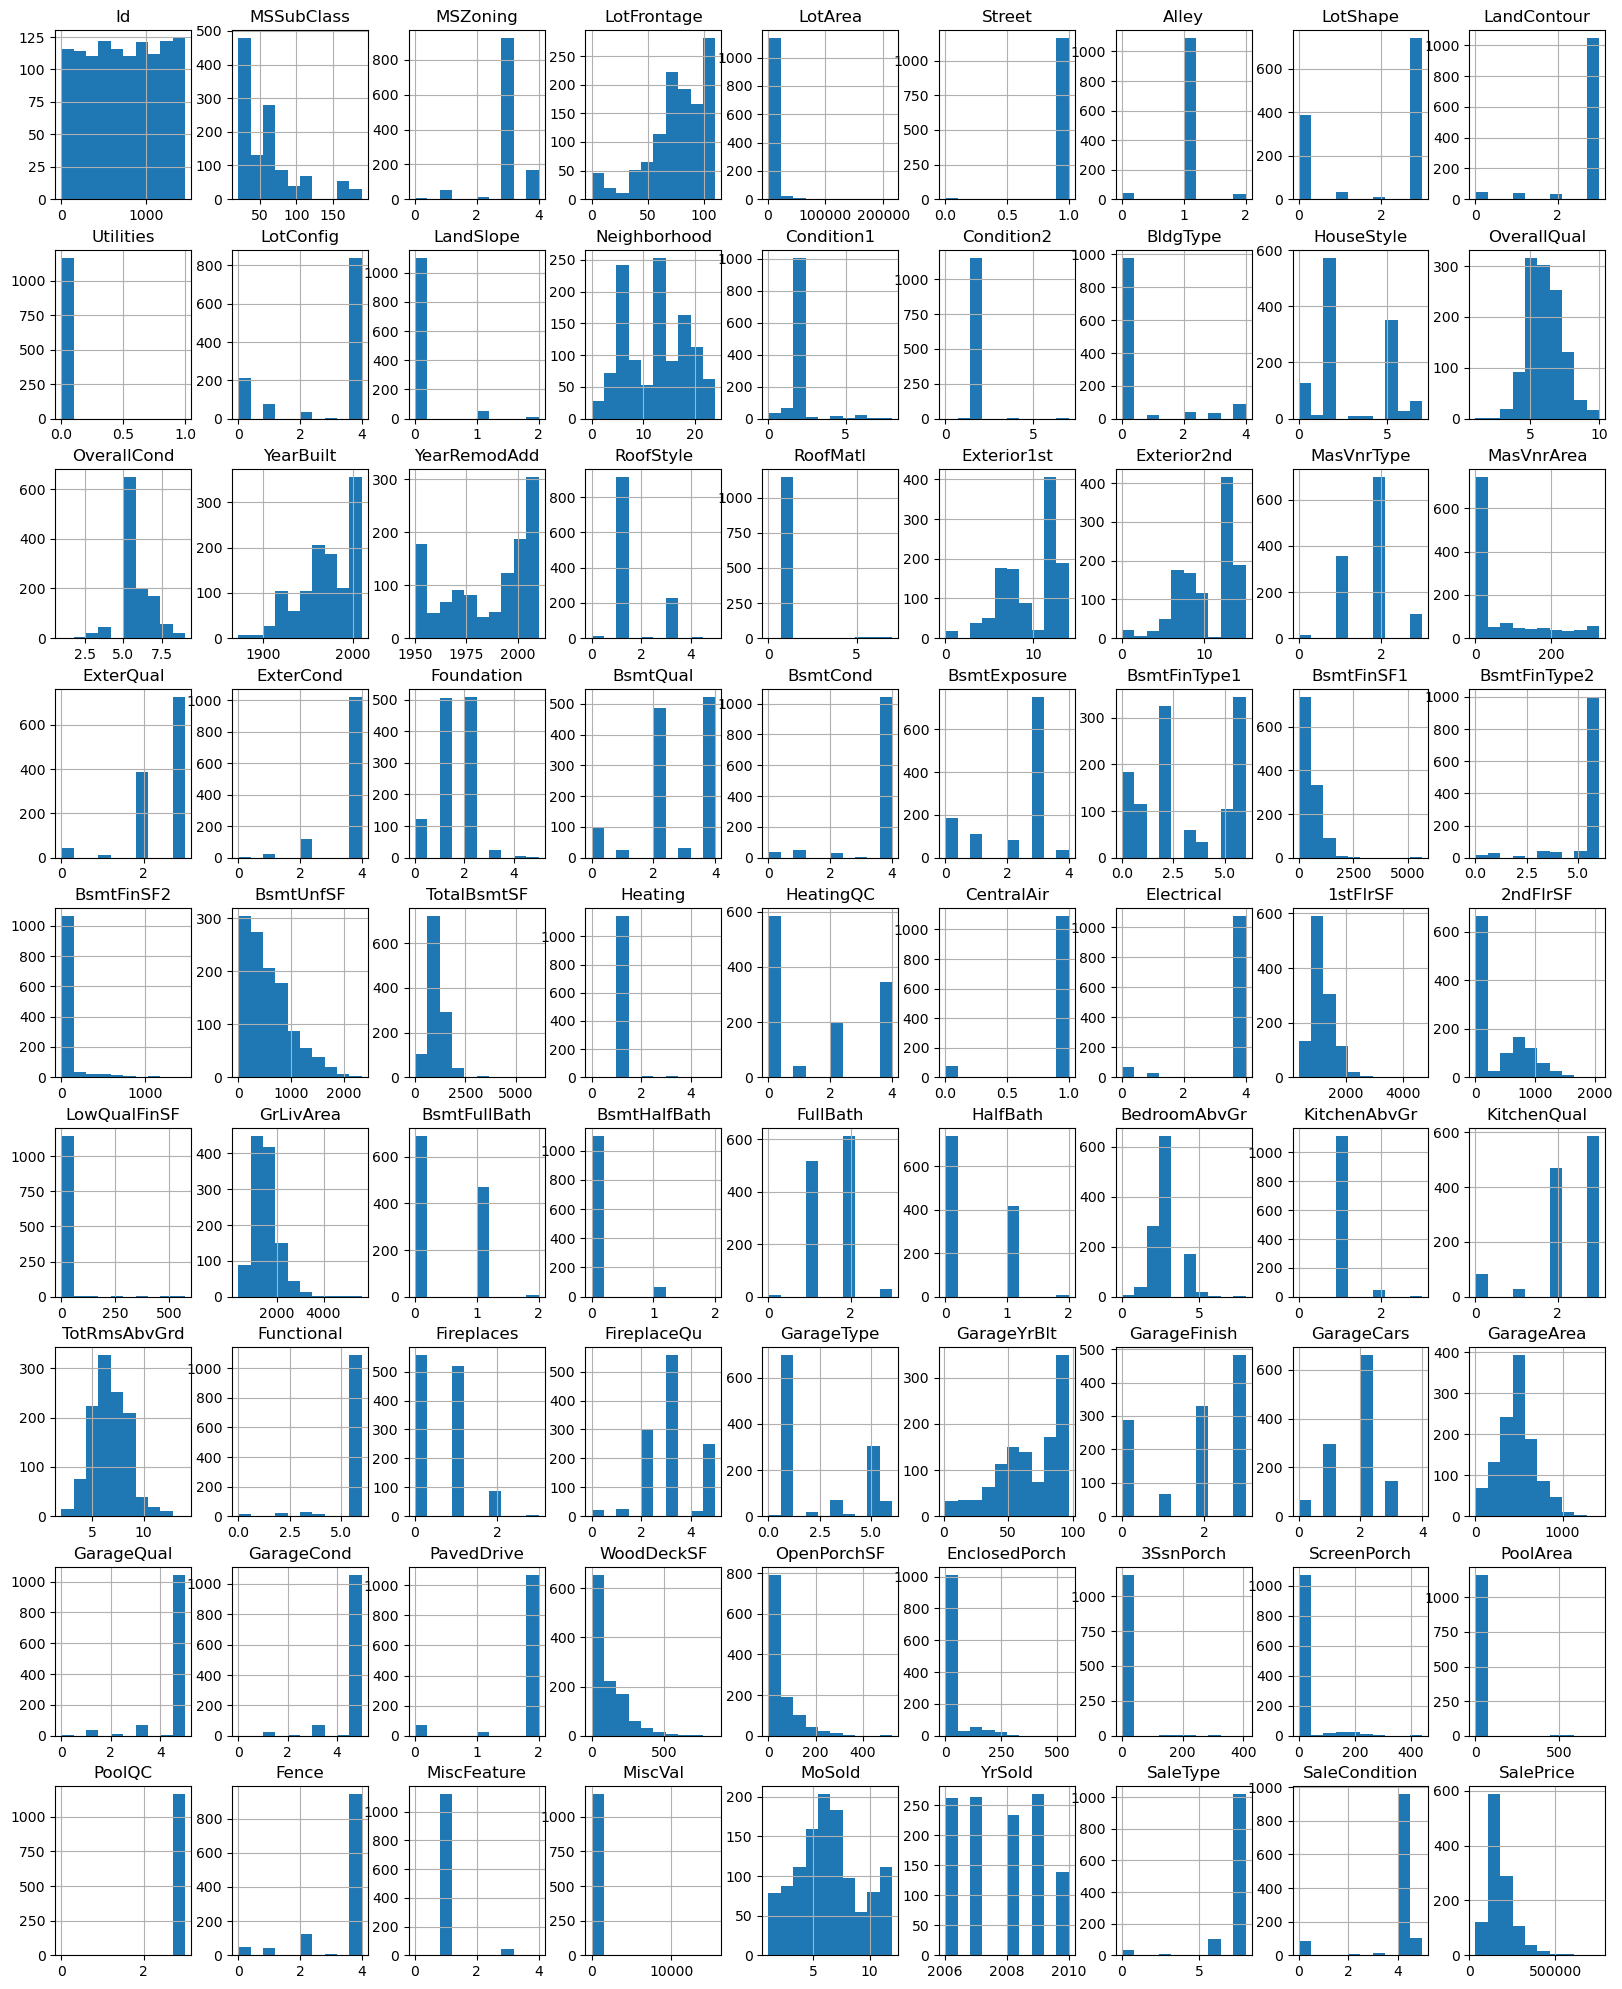

In [53]:
train_data.hist(figsize=(20,25))
plt.show()

Normalicing the variables skewed to the right

In [ ]:
right_skwed = [["MSSubClass", "LotArea", "BsmtFinSF1", ""]]